In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import ada_lib_jit as ada
import imp
import math
from numba import njit

imp.reload(ada)
plt.style.use('grayscale')

<IPython.core.display.Javascript object>


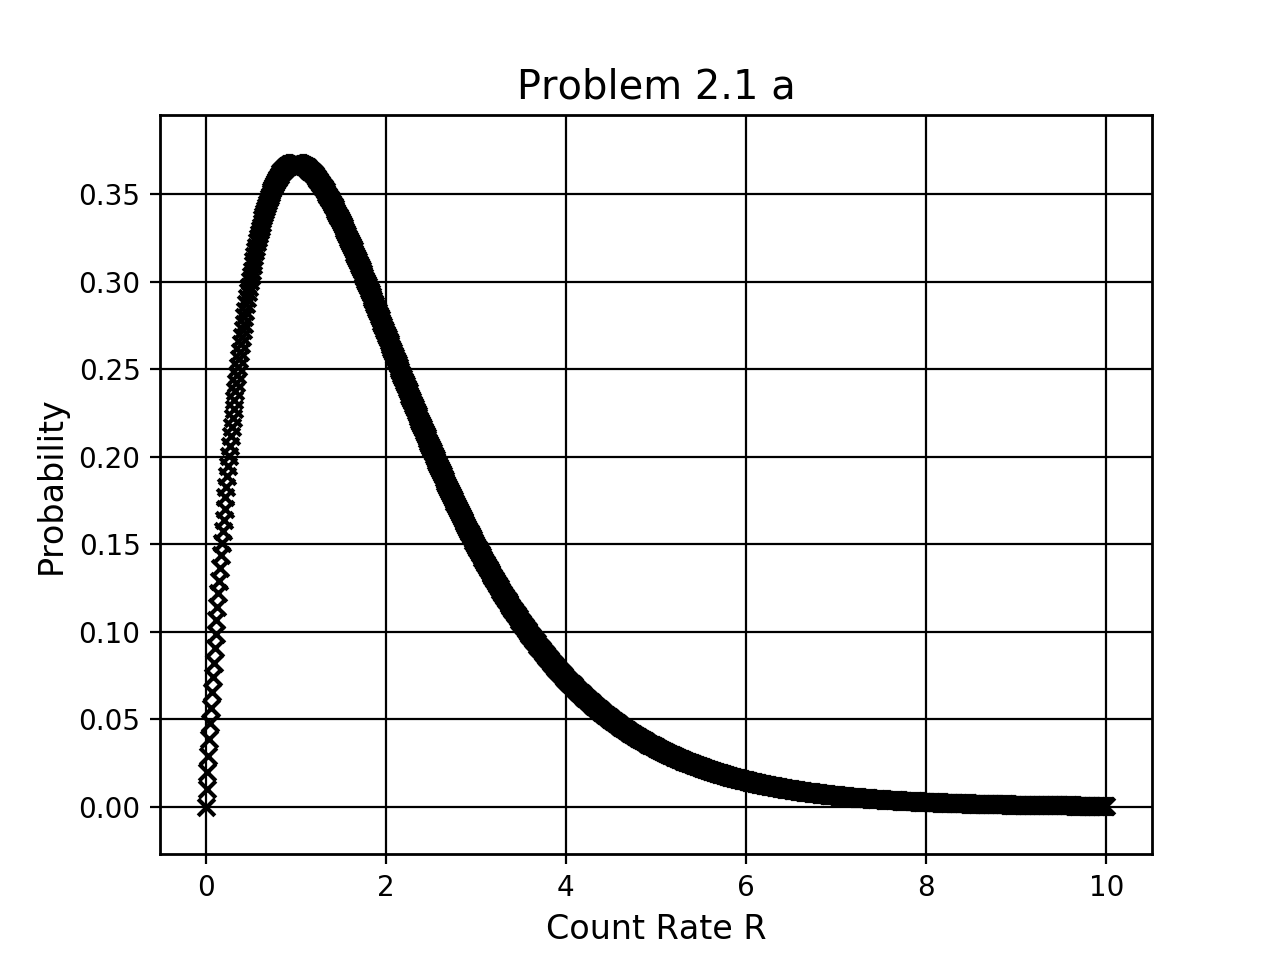

In [10]:
def poisson_P(val, R):
    return np.exp(-R)*R**val/(math.factorial(val))

R = np.linspace(0, 10, 1000)

f, ax = plt.subplots()
ax.scatter(R,poisson_P(1,R), marker ='x')
ax.set_title('Problem 2.1 a')
ax.set_xlabel('Count Rate R')
ax.set_ylabel('Probability')
plt.savefig('HW2/Report/Images/21a.pdf', format = 'pdf', dpi = 800)
plt.show()

In [11]:
f_i_data = np.array([110,160,90])
f_i_sigma = np.array([10,20,10])
wav_data = np.array([80, 105, 120])

In [12]:
delta = 5.0
wav_c = 100.0

@njit(cache = True, nogil = True)
def G(wav):
    return 1/(np.sqrt(2*np.pi)*delta)*np.exp(-0.5*((wav-wav_c)/(delta))**2)
    
@njit(cache = True, nogil = True)
def F(wav, C_ml, A_ml):
    return C_ml+A_ml*G(wav)

@njit(cache = True, nogil = True)
def F_orth(wav, C_ml, A_ml, G_hat):
    return C_ml+A_ml*(G(wav)-G_hat)



In [13]:
A = 0
C = 0

error = C_old = A_old = 1

i = 0

while(error > 1e-15):
    C = np.sum((f_i_data - A*G(wav_data))/(f_i_sigma**2))/(np.sum(1/f_i_sigma**2))

    top = np.sum( (f_i_data - C)*G(wav_data)/(f_i_sigma)**2 )
    A = top/np.sum( G(wav_data)**2/(f_i_sigma)**2 )
    i += 1
    error = np.max([np.abs(C_old -C), np.abs(A_old - A)])
    C_old = C
    A_old = A
print(f'{i} and {C} and {A}')

C_ml = C
A_ml = A

18 and 99.9667965734949 and 1240.505510445657


In [14]:
# DONT FORGET THE SQRT!
sigma_C_ml = np.sqrt(1/np.sum((1/f_i_sigma)**2))
sigma_A_ml = np.sqrt(1/np.sum(G(wav_data)**2/f_i_sigma**2))
print(sigma_C_ml, sigma_A_ml)

6.66666666667 413.272629728


In [15]:
lambda_range = np.linspace(75,120,1000)

<IPython.core.display.Javascript object>


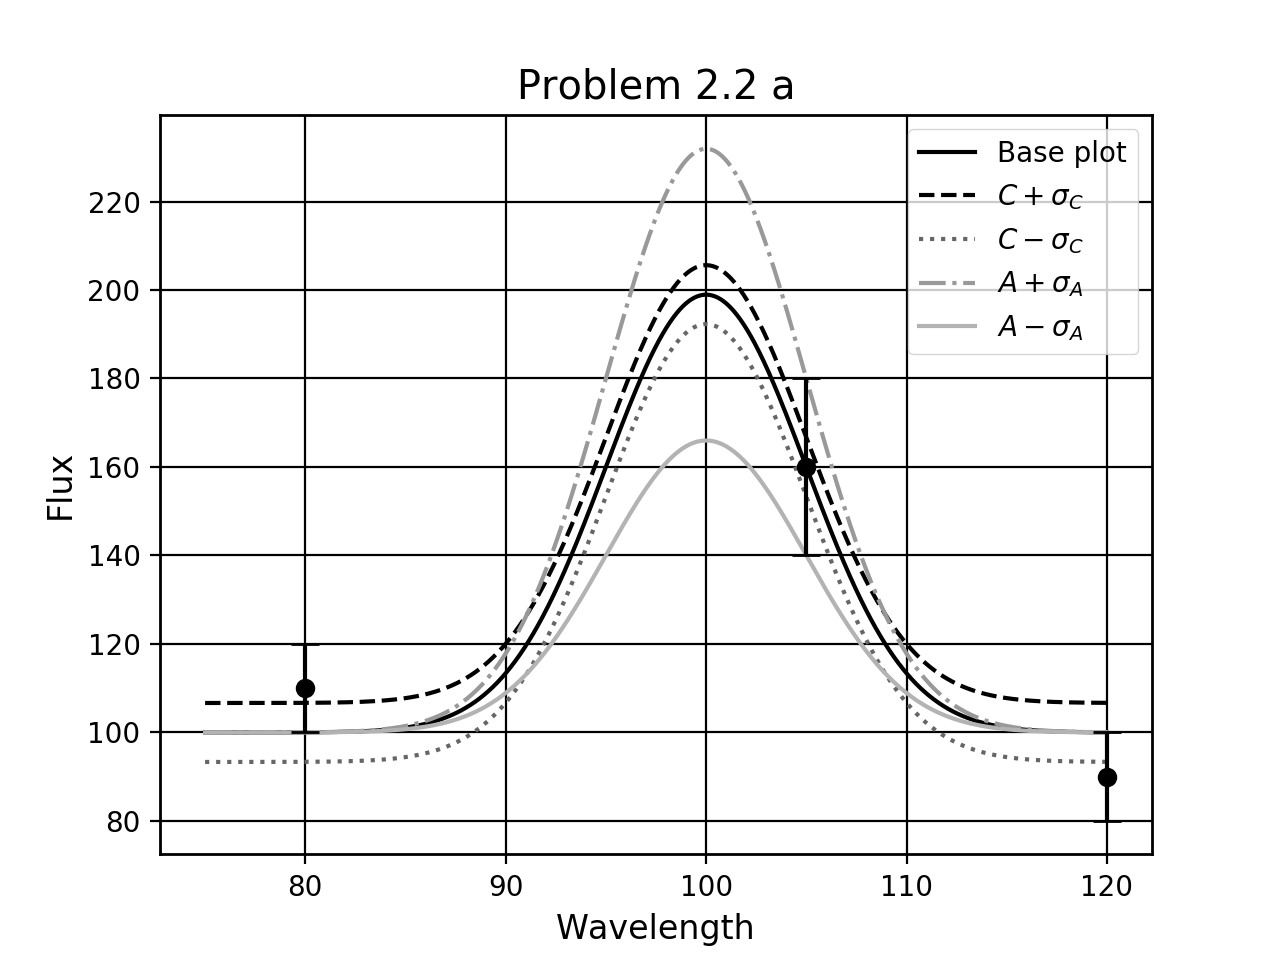

In [16]:
f, ax = plt.subplots()
ax.errorbar(wav_data, f_i_data, f_i_sigma, fmt = 'o', capsize = 5, zorder = 5, color = 'k')
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml), color = 'k')

# ++
ax.plot(lambda_range, F(lambda_range, C_ml+sigma_C_ml, A_ml), linestyle = 'dashed')
# --
ax.plot(lambda_range, F(lambda_range, C_ml-sigma_C_ml, A_ml), linestyle = 'dotted')
# -+
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml+sigma_A_ml), linestyle = '-.')
# +-
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml-sigma_A_ml))

ax.legend(['Base plot',r'$C + \sigma_C$',r'$C - \sigma_C$',r'$A + \sigma_A$','$A - \sigma_A$'])

ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_title('Problem 2.2 a')

plt.savefig('HW2/Report/Images/22a.pdf', dpi = 800, format = 'pdf')

In [17]:
@njit(cache = True, nogil = True)
def chi_2(data, fit, var):
    return np.sum(((data-fit)/var)**2)

In [18]:
# define the best working fit
best_fit_f = F(wav_data, C_ml, A_ml)
best_chi2 = chi_2(f_i_data, best_fit_f, f_i_sigma)

In [19]:
best_chi2

1.9999999999999998

In [20]:
@njit(cache = True, nogil = True)
def chi_space(N):
    a_scape = np.linspace(-0.5*A_ml, 2.5*A_ml, N)
    c_scape = np.linspace(50, 1.5*C_ml, N)

    r = np.zeros((N,N))

    for i, a in enumerate(a_scape):
        for j, c in enumerate(c_scape):
            new_fit = F(wav_data, c, a)
            new_chi2 = chi_2(f_i_data, new_fit, f_i_sigma)
            r[i,j] = new_chi2 - best_chi2
            
    return (r, a_scape, c_scape)

<IPython.core.display.Javascript object>


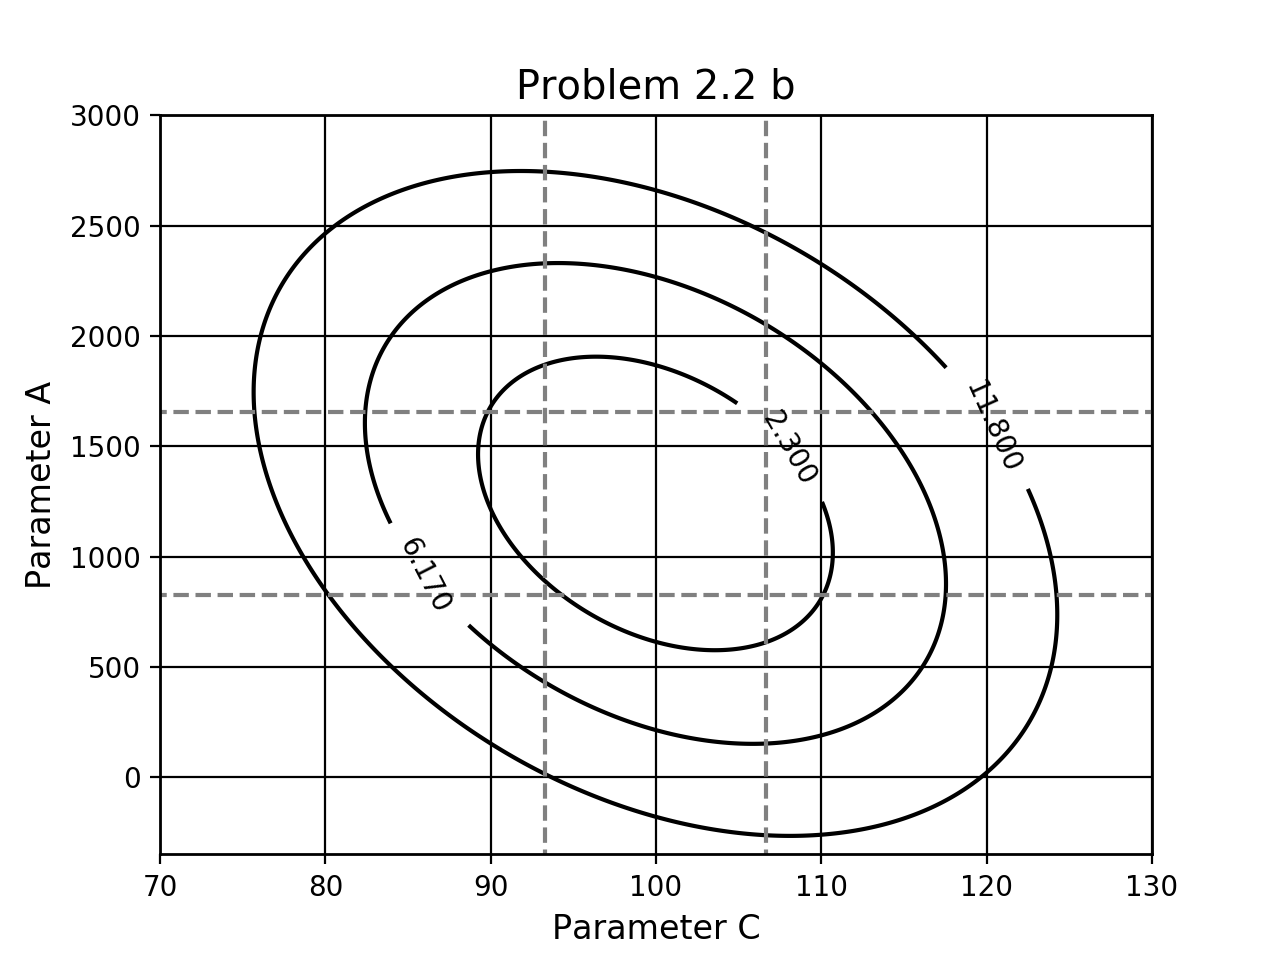

In [23]:
r,a_scape, c_scape = chi_space(1000)
f, ax = plt.subplots()
c = ax.contour(c_scape,a_scape,r,[2.3, 6.17, 11.8], colors = ('k','k','k'))

ax.clabel(c, [2.3,6.17,11.8], inline = 1, zorder = 0)

ax.hlines(A_ml+sigma_A_ml,0,500, linestyles = 'dashed',color = 'gray')
ax.hlines(A_ml-sigma_A_ml,0,500, linestyles = 'dashed',color = 'gray')

ax.vlines(C_ml+sigma_C_ml, -500, 3000, linestyles = 'dashed', color = 'gray')
ax.vlines(C_ml-sigma_C_ml, -500, 3000, linestyles = 'dashed', color = 'gray')

ax.set_xlim(70,130)
ax.set_ylim(-350,3000)

ax.set_xlabel('Parameter C')
ax.set_ylabel('Parameter A')
ax.set_title('Problem 2.2 b')

plt.savefig('HW2/Report/Images/countour22b.pdf', format = 'pdf', dpi = 800)

In [24]:
pattern = G(wav_data)
H = np.array([[np.sum(pattern**2/f_i_sigma**2),np.sum(pattern/f_i_sigma**2)],[np.sum(pattern/f_i_sigma**2),np.sum(1/f_i_sigma**2)]])
Hi = ada.func_invert_mat(H)

In [25]:
sigma_A_Hi = np.sqrt(Hi[0,0])
sigma_C_Hi = np.sqrt(Hi[1,1])
cov_A_C_Hi = Hi[0,1]

R = cov_A_C_Hi/(sigma_A_Hi*sigma_C_Hi)
print(sigma_A_Hi, sigma_C_Hi, cov_A_C_Hi, R)

438.584929268 7.07498953021 -1038.90322123 -0.334807815313


<IPython.core.display.Javascript object>


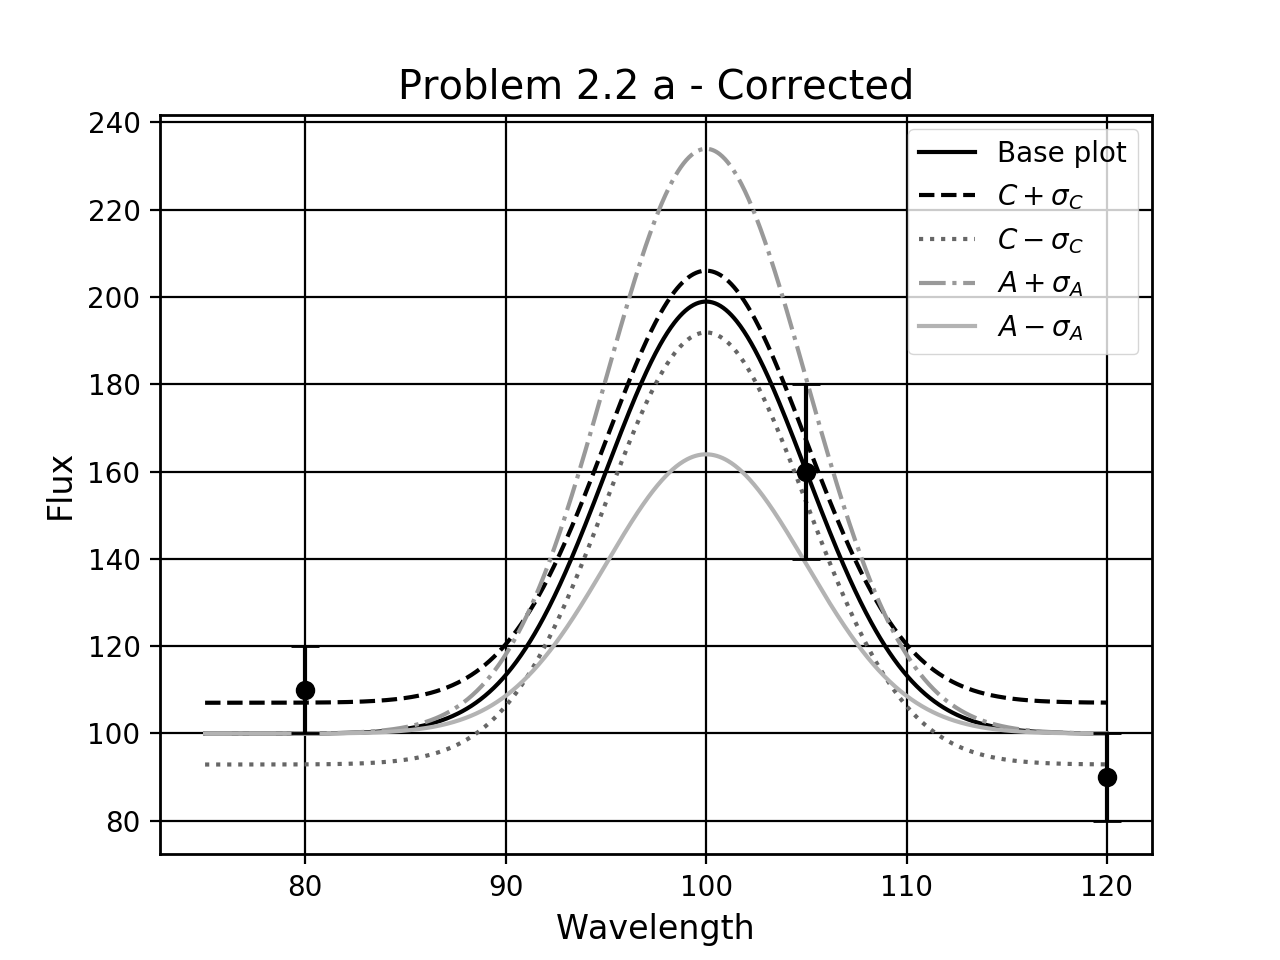

In [26]:
# replot using the correct variances

f, ax = plt.subplots()
ax.errorbar(wav_data, f_i_data, f_i_sigma, fmt = 'o', capsize = 5, zorder = 5, color = 'k')
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml), color = 'k')

# ++
ax.plot(lambda_range, F(lambda_range, C_ml+sigma_C_Hi, A_ml), linestyle = 'dashed')
# --
ax.plot(lambda_range, F(lambda_range, C_ml-sigma_C_Hi, A_ml), linestyle = 'dotted')
# -+
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml+sigma_A_Hi), linestyle = '-.')
# +-
ax.plot(lambda_range, F(lambda_range, C_ml, A_ml-sigma_A_Hi))

ax.legend(['Base plot',r'$C + \sigma_C$',r'$C - \sigma_C$',r'$A + \sigma_A$','$A - \sigma_A$'])

ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_title('Problem 2.2 a - Corrected')

plt.savefig('HW2/Report/Images/22a_correct_var.pdf', format = 'pdf', dpi = 800)

<IPython.core.display.Javascript object>


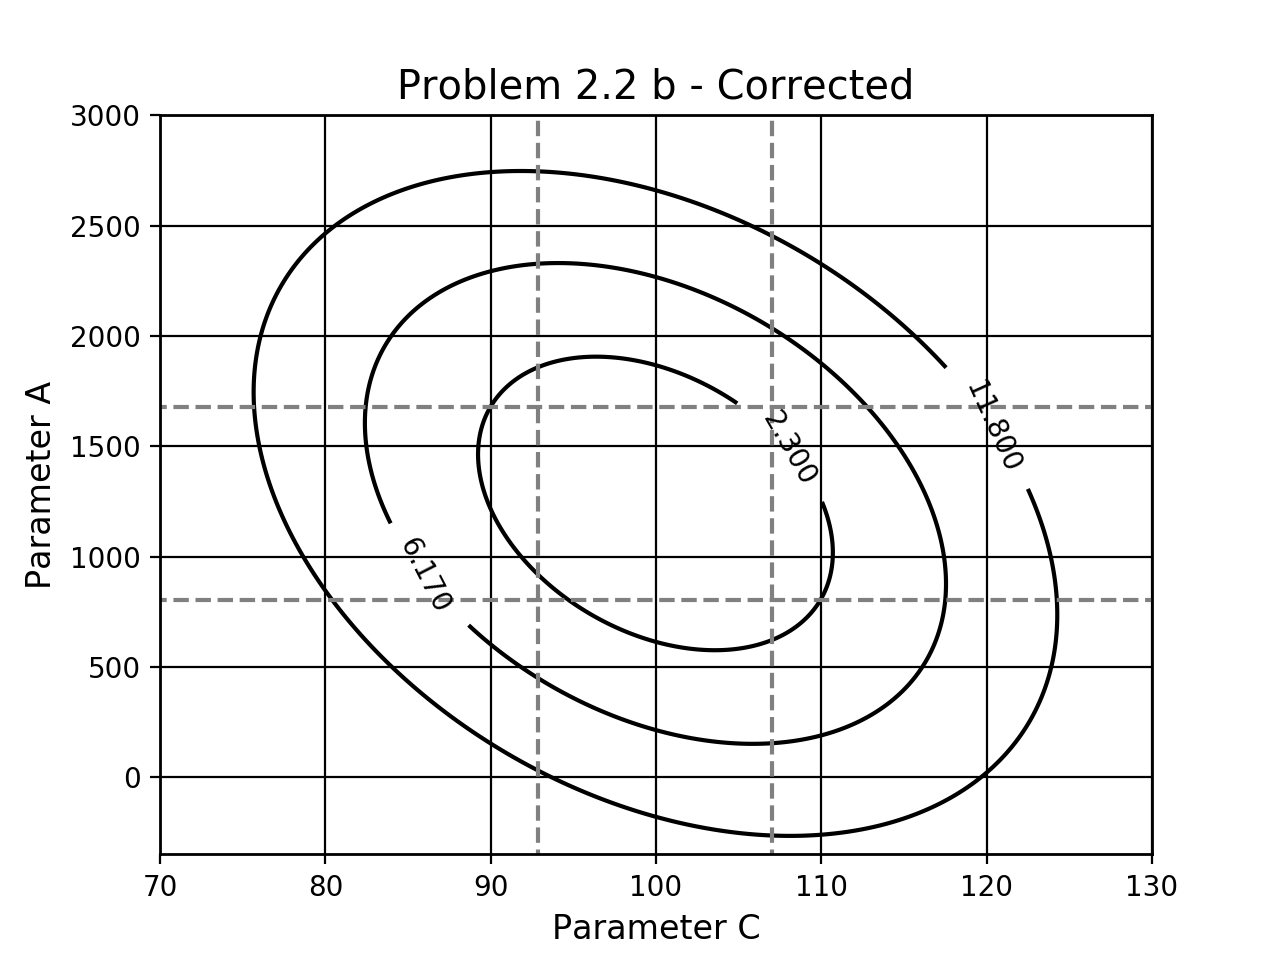

In [29]:
# r,a_scape, c_scape = chi_space(1000)
# 
# WE ARE CREATING A SECOND PLOT HERE TO SHOW THE DIFFERENCE IN SIGMA DONT BE STUPID AND DELETE THIS
# WE ARE CREATING A SECOND PLOT HERE TO SHOW THE DIFFERENCE IN SIGMA DONT BE STUPID AND DELETE THIS
# WE ARE CREATING A SECOND PLOT HERE TO SHOW THE DIFFERENCE IN SIGMA DONT BE STUPID AND DELETE THIS
# 

f, ax = plt.subplots()
c = ax.contour(c_scape,a_scape,r,[2.3, 6.17, 11.8], colors = ('k','k','k'))

ax.clabel(c, [2.3,6.17,11.8], inline = 1, zorder = 0)

ax.hlines(A_ml+sigma_A_Hi,0,500, linestyles = 'dashed',color = 'gray')
ax.hlines(A_ml-sigma_A_Hi,0,500, linestyles = 'dashed',color = 'gray')

ax.vlines(C_ml+sigma_C_Hi, -500, 3000, linestyles = 'dashed',color = 'gray')
ax.vlines(C_ml-sigma_C_Hi, -500, 3000, linestyles = 'dashed',color = 'gray')

ax.set_xlim(70,130)
ax.set_ylim(-350,3000)

ax.set_xlabel('Parameter C')
ax.set_ylabel('Parameter A')
ax.set_title('Problem 2.2 b - Corrected')

plt.savefig('HW2/Report/Images/Correct_var_cont.pdf', format = 'pdf', dpi = 800)

In [30]:
# see 9C
Hess_D = ada.func_determinant(H)
G_hat = H[0,1]/H[1,1]
Hess_D2 = np.sum(1/(f_i_sigma**2))*(np.sum((pattern-G_hat)**2/(f_i_sigma)**2))

C_orth = (np.sum(f_i_data/f_i_sigma**2))/(np.sum(1/f_i_sigma**2))
A_orth = (np.sum((pattern - G_hat)*f_i_data/f_i_sigma**2))/(np.sum((pattern - G_hat)**2/f_i_sigma**2))

In [31]:
best_fit_f_orth = F_orth(wav_data, C_orth, A_orth, G_hat)
best_chi2_orth = chi_2(f_i_data, best_fit_f_orth, f_i_sigma)

@njit(cache = True, nogil = False)
def chi_space_orth(N):
    a_scape = np.linspace(-500, 3000, N)
    c_scape = np.linspace(80, 135, N)
    r = np.zeros((N,N))
    
    for i, a in enumerate(a_scape):
        for j, c in enumerate(c_scape):
            new_fit = F_orth(wav_data, c, a, G_hat)
            new_chi2 = chi_2(f_i_data, new_fit, f_i_sigma)
            r[i,j] = new_chi2 - best_chi2_orth
#             print(f'{a}, {i}, {new_chi2-best_chi2_orth}')
    return (r, a_scape, c_scape)

In [32]:
ro, ao, co = chi_space_orth(1000)

<IPython.core.display.Javascript object>


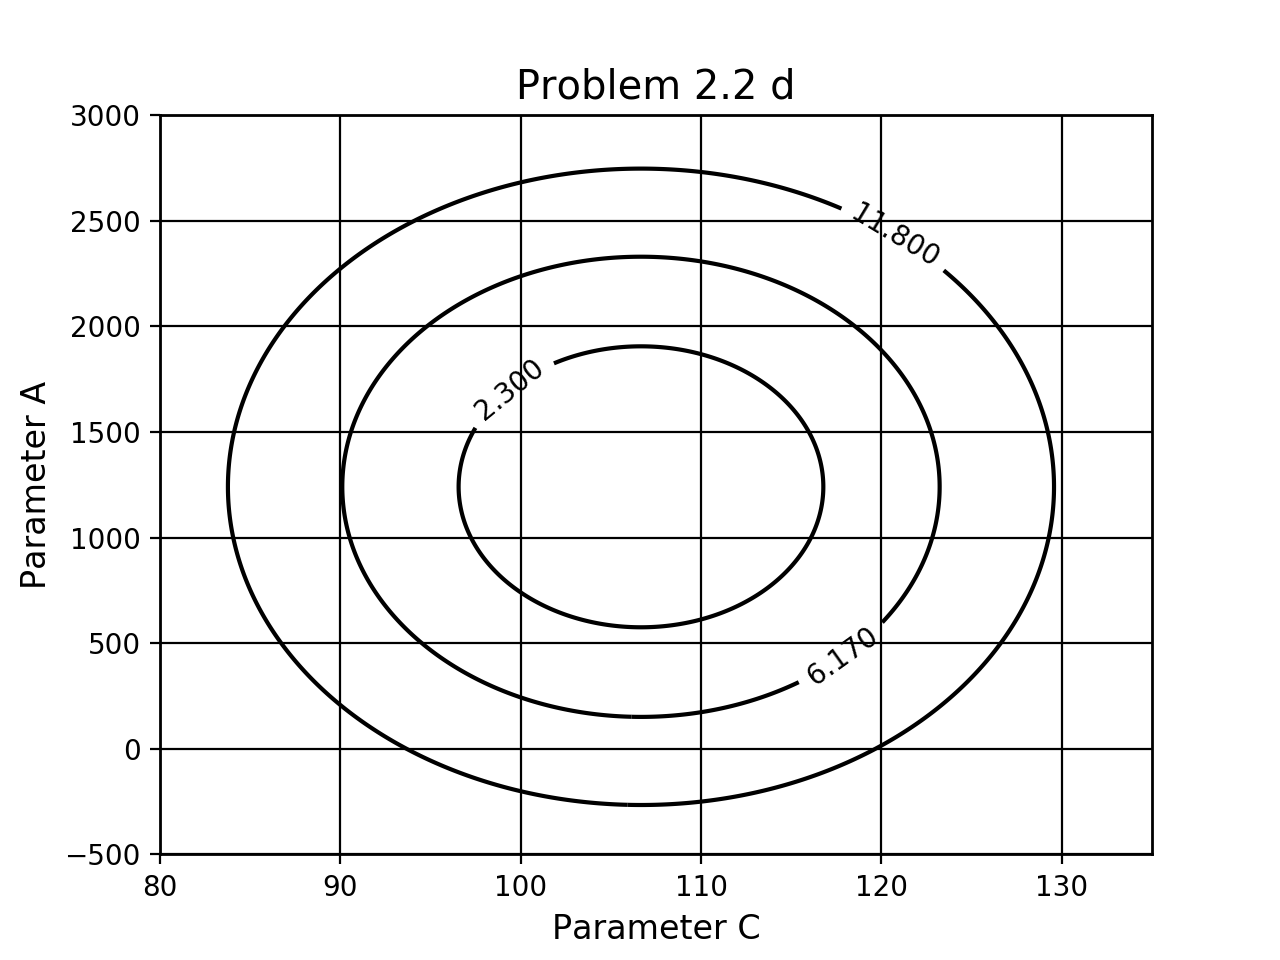

In [33]:
f, ax = plt.subplots()
c = ax.contour(co,ao,ro,[2.3, 6.17, 11.8], colors = ('k','k','k'))
ax.clabel(c, [2.3,6.17,11.8], inline = 1, zorder = 0)

ax.set_xlabel('Parameter C')
ax.set_ylabel('Parameter A')
ax.set_title('Problem 2.2 d')

plt.savefig('HW2/Report/Images/22d_orth.pdf', format = 'pdf', dpi = 800)

<IPython.core.display.Javascript object>


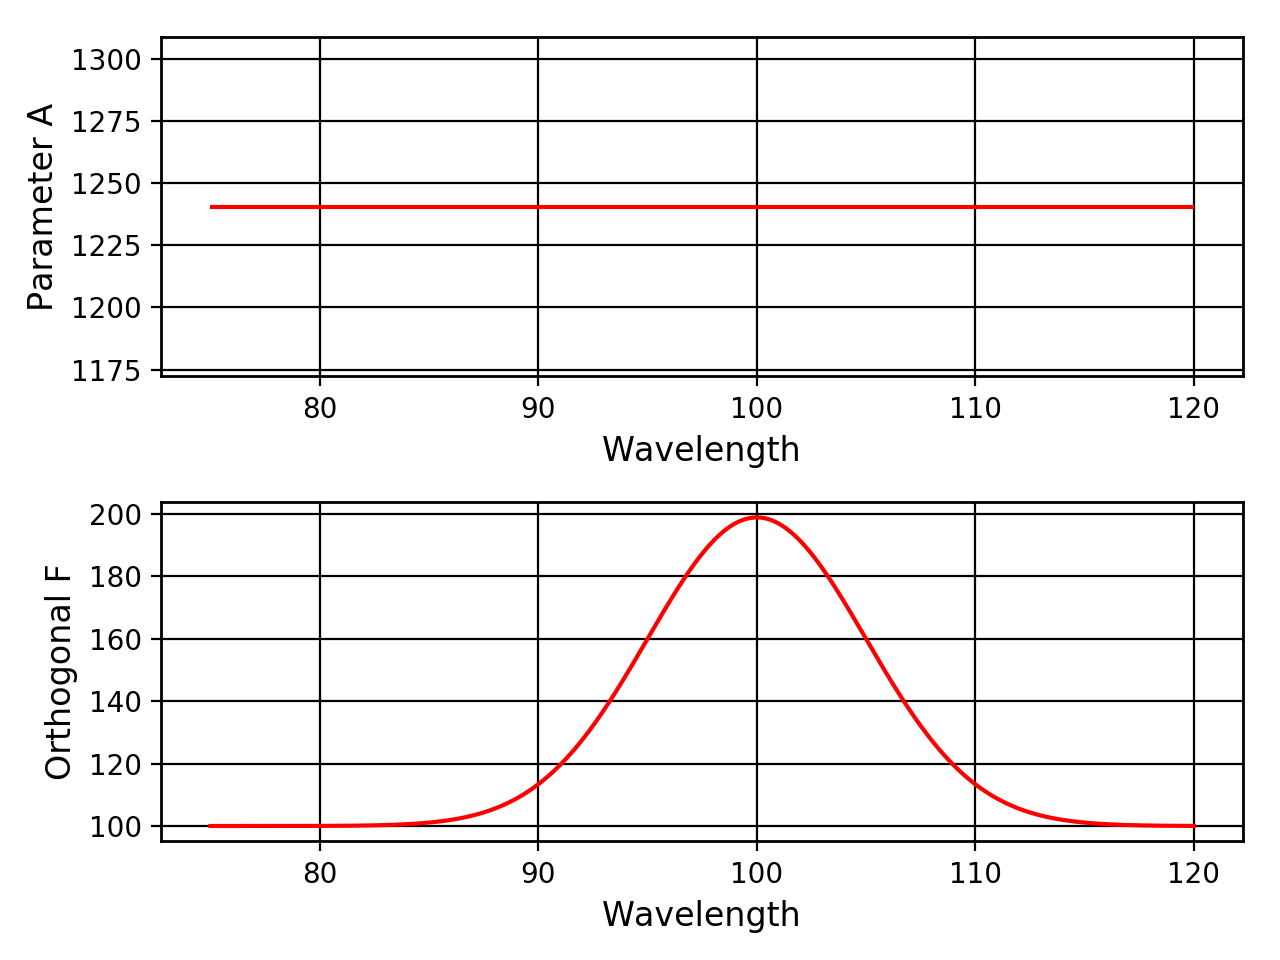

In [52]:
def a_orth(val):
    return A_orth

f, axs = plt.subplots(2,1)
# axs[0].plot(a_orth(lambda_range),lambda_range,color = 'r')
axs[0].hlines(A_orth, np.min(lambda_range), np.max(lambda_range), color = 'r')
axs[0].set_xlabel('Wavelength')
axs[0].set_ylabel('Parameter A')

axs[1].plot(lambda_range,F_orth(lambda_range,C_orth, A_orth, G_hat), color = 'r')
axs[1].set_xlabel('Wavelength')
axs[1].set_ylabel('Orthogonal F')

plt.tight_layout()
plt.savefig('HW2/Report/Images/22d_params.pdf', dpi = 800, format = 'pdf')

In [53]:
seed = 100
N = 1000000
P_samp = ada.func_rand_gaussian(86400*6.4714,0.0001*86400, seed, N)
Kc_samp = ada.func_rand_gaussian(208.5*1000,0.7*1000, seed, N)
Vrot_sini_samp = ada.func_rand_gaussian(38.8*1000, 1.1*1000, seed, N)

M_C = np.zeros(N)
M_X = np.zeros(N)

low = np.cos(50*np.pi/180)
hi = np.cos(80*np.pi/180)

i_samp = np.arccos(ada.func_rand_uniform(low, hi, seed, N))

In [54]:
@njit(cache = True, nogil = False)
def mass_function(Kc, P):
    return P*Kc**3/(2*np.pi*6.67e-11)

@njit(cache = True, nogil = False)
def solve_q(vrotsini, Kc):
    test_q = np.arange(0,1,0.0001)
    diff = np.zeros(len(test_q))
    for i, q_t in enumerate(test_q):
        diff[i] = np.abs(vrotsini - 0.462*Kc*q_t**(1/3)*(1+q)**(2/3))
    return test_q[np.argmin(diff)]

In [55]:
solve_q(100,10)
F_X = mass_function(Kc_samp, P_samp)
M_C = F_X*(Vrot_sini_samp)**3/(0.462**3*Kc_samp**3*(np.sin(i_samp))**3)
# M_X = F_X/(np.sin(i_samp)**3)

M_C_solar = M_C/2e30
# M_X_solar = M_X/2e30

mean_M_C_solar, var_M_C_solar = ada.func_mean_var(M_C_solar)
# mean_M_X_solar, var_M_X_solar = ada.func_mean_var(M_X_solar)

# print(mean_M_C_solar, mean_M_X_solar, var_M_C_solar, var_M_X_solar)

In [84]:
for i in range(0, N):
    vrot = Vrot_sini_samp[i]
    Kc = Kc_samp[i]
    Mc = M_C[i]
    M_X[i] = Mc/solve_q(vrot, Kc)
    
M_X_solar = M_X/2e30
mean_M_X_solar, var_M_X_solar = ada.func_mean_var(M_X_solar)
print(mean_M_C_solar, mean_M_X_solar, np.sqrt(var_M_C_solar), np.sqrt(var_M_X_solar))

0.5598550722073229 9.4806560210762 0.135882033961 2.1508885397


<IPython.core.display.Javascript object>


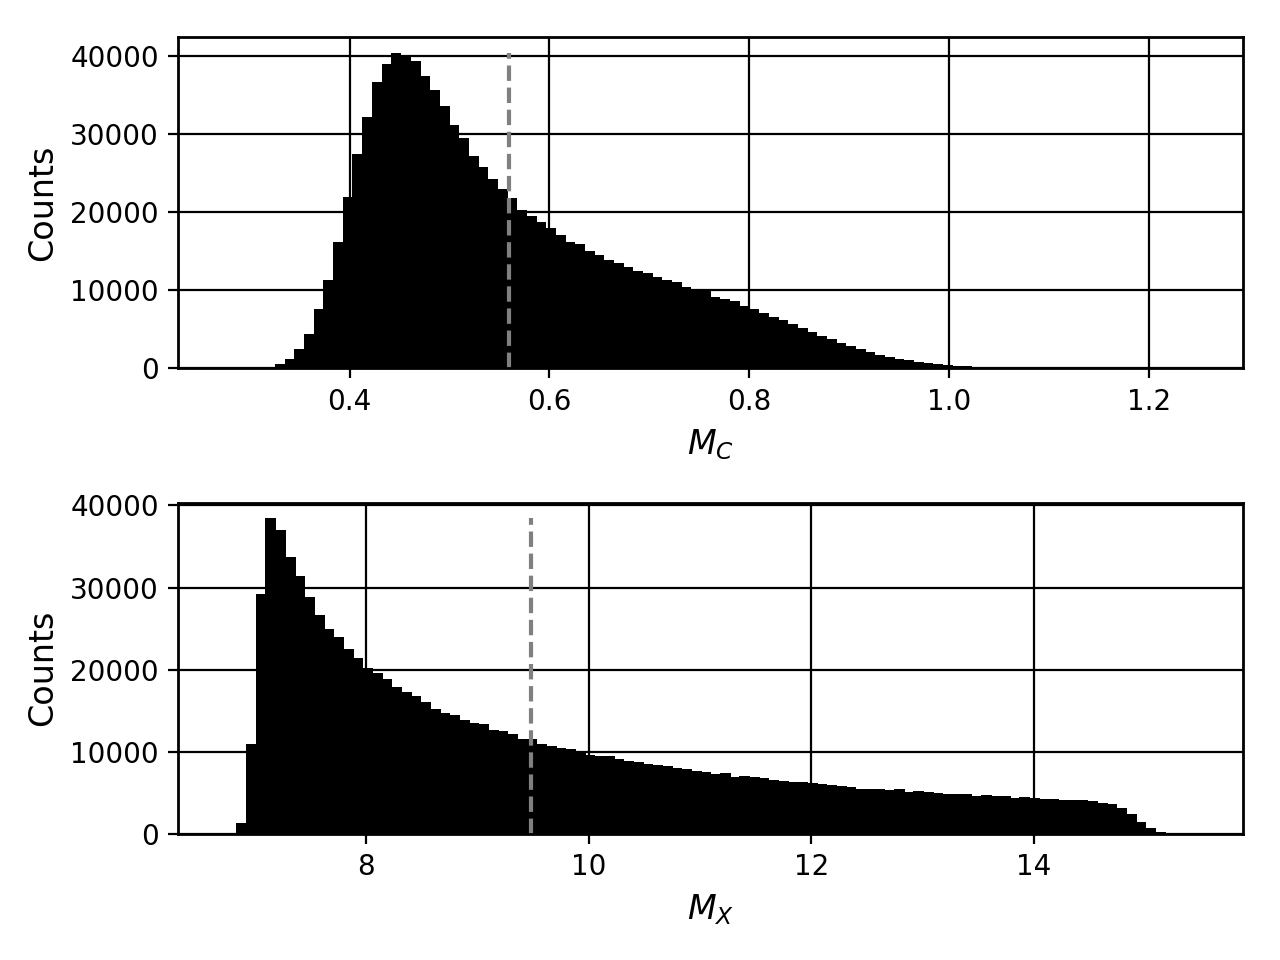

In [64]:
f, ax = plt.subplots(2,1)

hist, cumsum, bin_nums = ada.func_histogram(M_C_solar, 100, False)
ax[0].bar(bin_nums, hist, width = 0.01)
ax[0].vlines(mean_M_C_solar, 0, np.max(hist), linestyle = 'dashed', color = 'gray')
# ax[0].set_ylim(0,400)
ax[0].set_xlabel(r'$M_C$')
ax[0].set_ylabel('Counts')

hist, cumsum, bin_nums = ada.func_histogram(M_X_solar, 100, False)
ax[1].bar(bin_nums, hist, width = 0.1)
# ax[1].hist(M_X_solar, bins = 100, histtype = 'step', color = 'k')
ax[1].vlines(mean_M_X_solar, 0, np.max(hist), linestyle = 'dashed', color = 'gray')
ax[1].set_xlabel(r'$M_X$')
ax[1].set_ylabel('Counts')
# ax[1].set_ylim(0,400)
plt.tight_layout()
plt.savefig('HW2/Report/Images/2_3_Hist_data.pdf', format = 'pdf', dpi = 800)

plt.show()

<IPython.core.display.Javascript object>


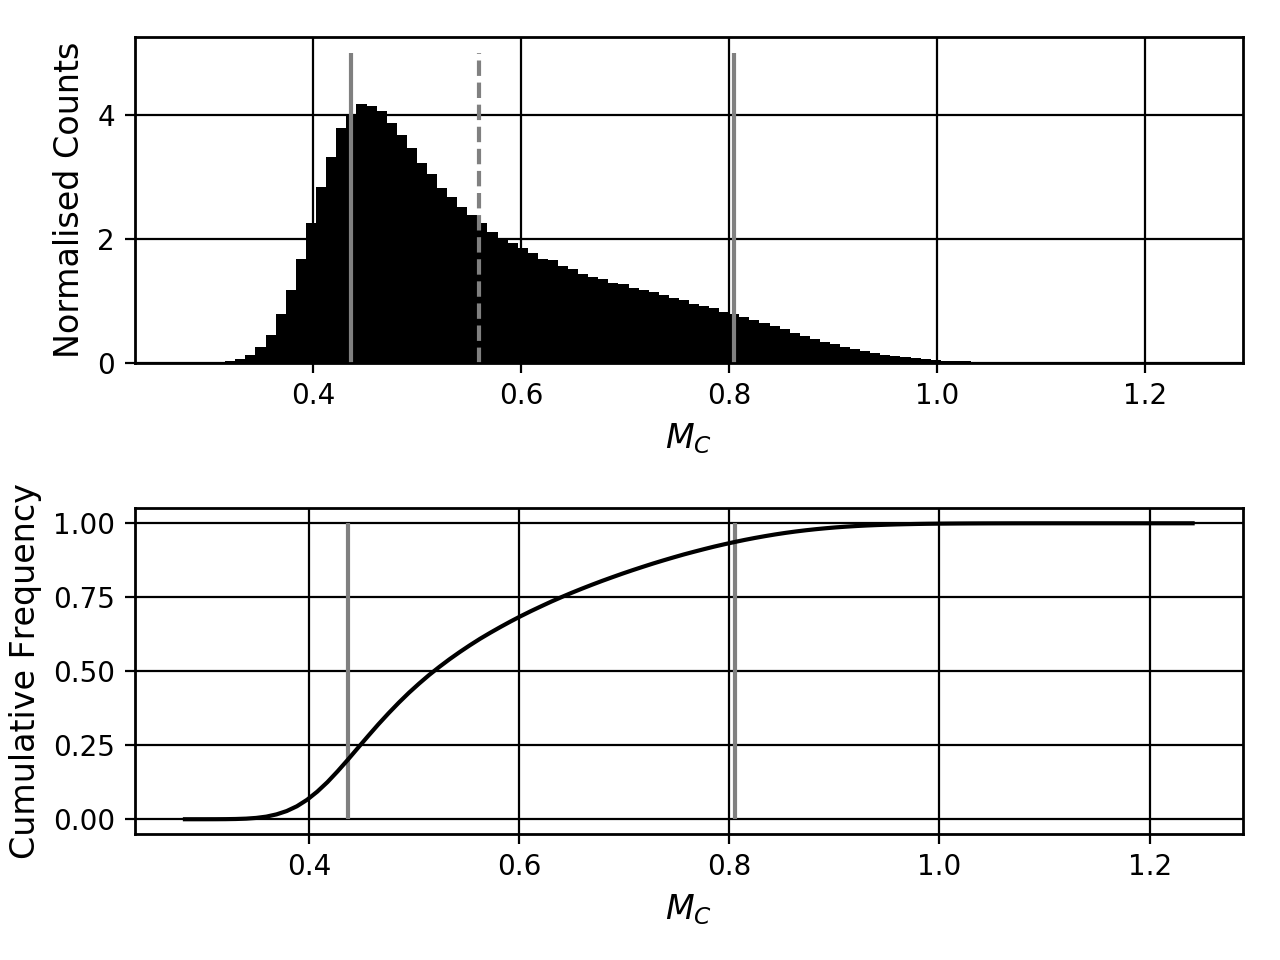

In [65]:
# AGAIN DONT DELETE BECAUSE HERE WE ARE NORMALISING EVERYTHING SO THAT IT WORKS CORRECTLY
# remember to explain everything but also remember that you can work out the widths using the step!
f, ax = plt.subplots(2,1)

hist_C, cumsum_C, bin_nums_C = ada.func_histogram(M_C_solar, 100, True)
ax[0].bar(bin_nums_C, hist_C, width = 0.01)
ax[0].vlines(mean_M_C_solar, 0, 5, linestyle = 'dashed', color = 'gray')
ax[0].vlines(bin_nums_C[16], 0, 5, color = 'gray')
ax[0].vlines(bin_nums_C[54], 0, 5, color = 'gray')
ax[0].set_xlabel(r'$M_C$')
ax[0].set_ylabel('Normalised Counts')

ax[1].plot(bin_nums_C, cumsum_C)
ax[1].vlines(bin_nums_C[16], 0, 1, color = 'gray')
ax[1].vlines(bin_nums_C[54], 0, 1, color = 'gray')
ax[1].set_xlabel(r'$M_C$')
ax[1].set_ylabel('Cumulative Frequency')

plt.tight_layout()
plt.savefig('HW2/Report/Images/2_6_M_C_Mass.pdf', format = 'pdf', dpi = 800)

plt.show()

<IPython.core.display.Javascript object>


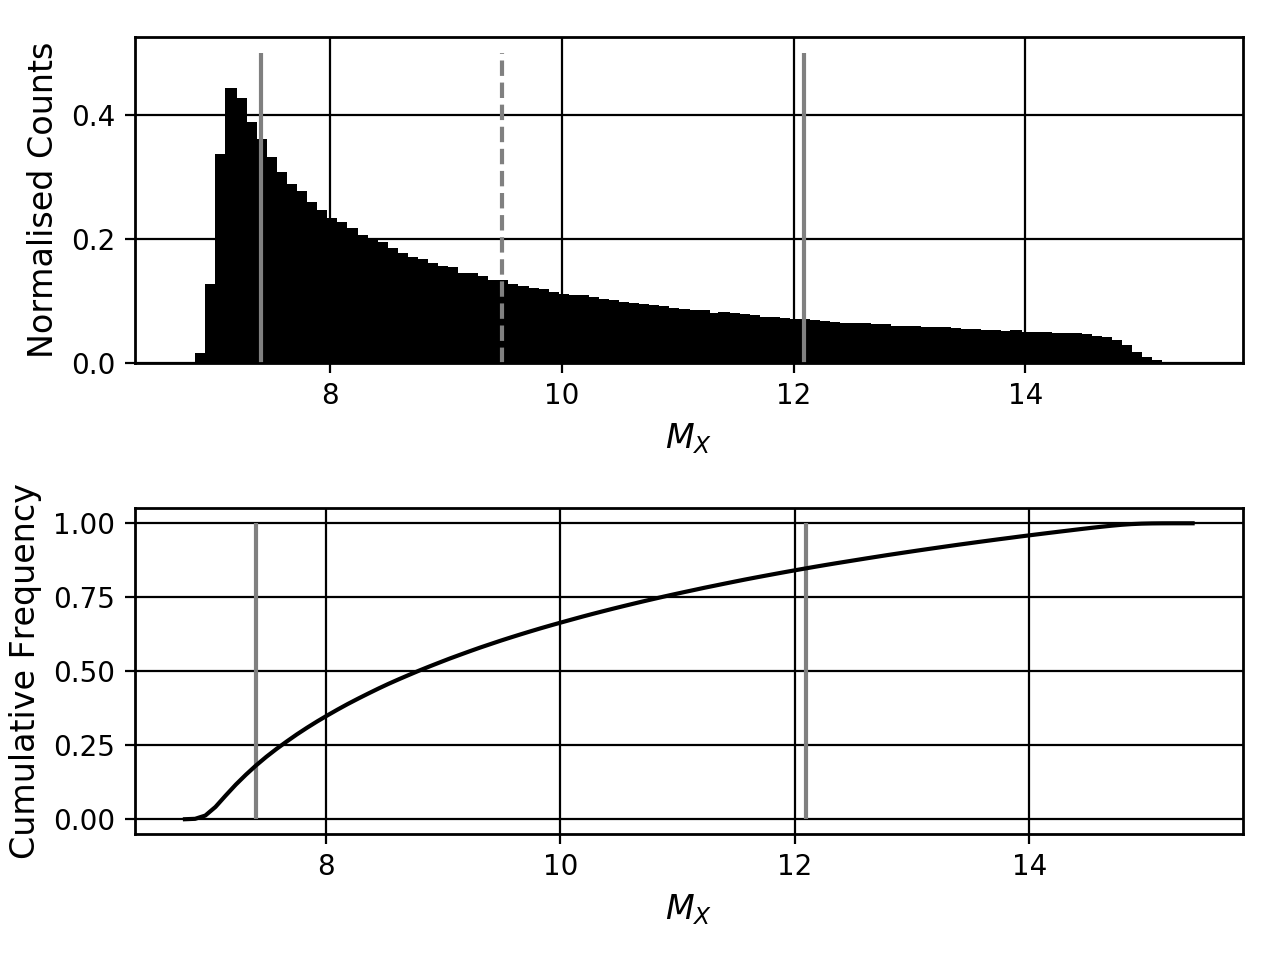

In [83]:
f, ax = plt.subplots(2,1)

hist_X, cumsum_X, bin_nums_X = ada.func_histogram(M_X_solar, 100, True)
ax[0].bar(bin_nums_X, hist_X, width = 0.1)
ax[0].vlines(mean_M_X_solar, 0, 0.5, linestyle = 'dashed', color = 'gray')
ax[0].vlines(bin_nums_X[7], 0, 0.5, color = 'gray')
ax[0].vlines(bin_nums_X[61], 0, 0.5, color = 'gray')
ax[0].set_xlabel(r'$M_X$')
ax[0].set_ylabel('Normalised Counts')

ax[1].plot(bin_nums_X, cumsum_X)
ax[1].vlines(bin_nums_X[7], 0, 1, color = 'gray')
ax[1].vlines(bin_nums_X[61], 0, 1, color = 'gray')
ax[1].set_xlabel(r'$M_X$')
ax[1].set_ylabel('Cumulative Frequency')
plt.tight_layout()

plt.savefig('HW2/Report/Images/2_6_M_X_Mass.pdf', format = 'pdf', dpi = 800)

In [68]:
def find_delta(data):
    height = [0.17,0.84]
    
    loc1 = 0
    loc2 = 0
    
    loc1 = np.argmin(np.abs(data - height[0]))
    loc2 = np.argmin(np.abs(data - height[1]))
    
    return loc1, loc2

In [85]:
p1,p2 = find_delta(cumsum_X)
pc1, pc2 = find_delta(cumsum_C)
print(bin_nums_C[pc1], bin_nums_C[pc2])

0.427325479532 0.708188400273


<IPython.core.display.Javascript object>


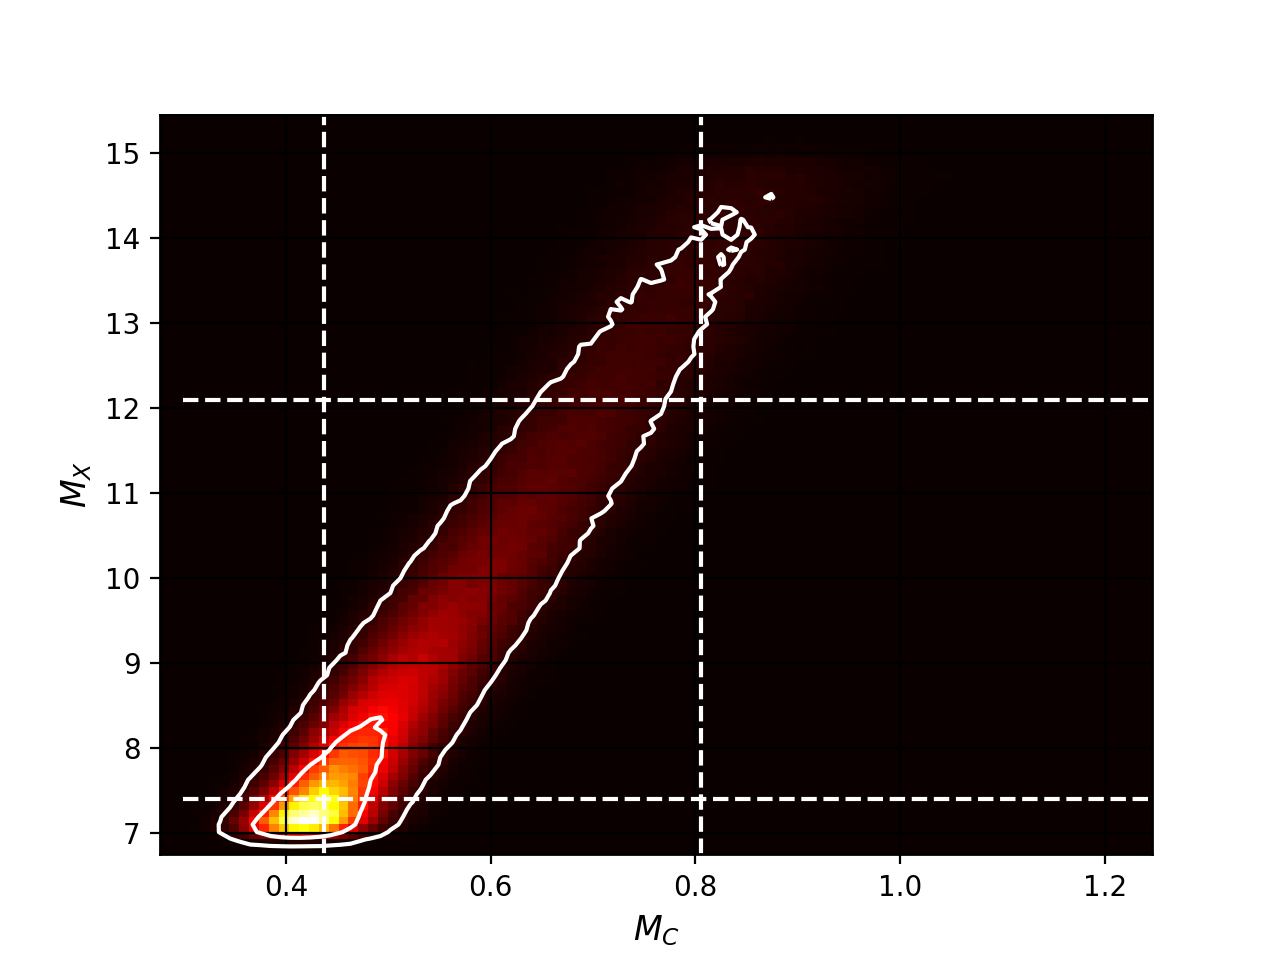

In [82]:
f, ax = plt.subplots()
counts, xedge, yedge, img = ax.hist2d(M_C_solar,M_X_solar, bins = 100, cmap = 'hot')
level = [0.046*1000000/200,0.32*1000000/200]
cs = ax.contour(counts.T, levels = level, colors = 'white', extent = (xedge[0], xedge[-1], yedge[0], yedge[-1]))
ax.hlines(bin_nums_X[7], 0.3, 1.3, color = 'white', linestyle = 'dashed')
ax.hlines(bin_nums_X[61], 0.3, 1.3, color = 'white', linestyle = 'dashed')
ax.vlines(bin_nums_C[16], 6.5, 15.5, color = 'white', linestyle = 'dashed')
ax.vlines(bin_nums_C[54], 6.5, 15.5, color = 'white', linestyle = 'dashed')

ax.set_ylabel(r'$M_X$')
ax.set_xlabel(r'$M_C$')
plt.savefig('HW2/Report/Images/finalfig.pdf', dpi = 800, format = 'pdf')
plt.show()

In [86]:
np.min(bin_nums_X)

6.7955806535784555